# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model in multiple conditions through different means

In [7]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import itertools
import multiprocessing
import os
import mne
import pyhsmm_mvpa as hsmm

cpus = multiprocessing.cpu_count()
print(cpus)
cpus = 10 #if not enough RAM to load all participants data, better reduce the number of processes

path = 'HsMM_files/'
version = '1024Hz'

80


# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [2]:
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events
sfreq = 1024#For resampling

eeg_path = 'preprocessed_data/'
subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(eeg_path) if 'preprocessed' in x]
print(subj_names)
subj_files = [eeg_path+ 'preprocessed_'+x+'.fif' for x in subj_names]

save_file = 'epoch_data_condition-wise_%s.nc'%version
if save_file not in os.listdir():#avoids to loop again if notebook is restarted
    with multiprocessing.Pool(processes=cpus) as pool:
        epoch_data = pool.starmap(hsmm.utils.read_mne_EEG, 
        zip([[x] for x in subj_files], itertools.repeat(event_id), itertools.repeat(resp_id),    
                itertools.repeat(sfreq), itertools.repeat(None), itertools.repeat(-.25), itertools.repeat(2), 
                itertools.repeat(.05), itertools.repeat(1), itertools.repeat(30), itertools.repeat(2), 
                itertools.repeat(.25)))
    
    epoch_data = xr.concat(epoch_data, pd.Series(subj_names, name="participant"),
                          fill_value={'event':'', 'data':np.nan})#not sure about the order of the particiapnt use with caution
    epoch_data.to_netcdf(save_file)
    epoch_data = xr.open_dataset(save_file)#For an unknown reason I need to re-read it
else:
    epoch_data = xr.open_dataset(save_file)

raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)#loading for sensor position
raw.set_montage(mne.channels.make_standard_montage('biosemi64'))

['S8', 'S6', 'S1', 'S18', 'S11', 'S16', 'S7', 'S9', 'S17', 'S10', 'S13', 'S14', 'S4', 'S3', 'S15', 'S12', 'S20', 'S2', 'S5']


/tmp/ipykernel_3514348/2543545682.py:29: RuntimeWarning: This filename (preprocessed_data/preprocessed_S8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)#loading for sensor position


<Raw | preprocessed_S8.fif, 72 x 5107712 (4988.0 s), ~101 kB, data not loaded>

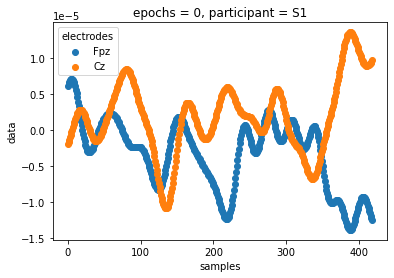

In [3]:
#example of usage of xarray
epoch_data.sel(epochs=0,electrodes=['Fpz','Cz'],participant='S1').plot.scatter(x='samples', y='data',hue='electrodes')

## Applying standardization, variance scaling and PCA

In [4]:
hsmm_dat, PCs, explained_var, means = hsmm.utils.transform_data(epoch_data,'participant',return_weights=True, n_comp=10)

# Applying HsMM for all conditions

Initializing model

In [5]:
hsmm_data = hsmm.utils.stack_data(hsmm_dat,'participant')
init = hsmm.models.hsmm(hsmm_data.data.T, hsmm_data.starts.data, hsmm_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [8]:
filename = 'SAT_bests_%s.nc'%version

if filename not in os.listdir(path):
    bests = init.backward_estimation(max_starting_points=1)
    bests.to_netcdf(path+filename)
else:
    bests = xr.open_dataset(path+filename)
bests

<xarray.Dataset>
Dimensions:      (n_bumps: 5, samples: 2046, trial: 41078, bump: 5, component: 10, stage: 6, params: 2)
Coordinates:
  * n_bumps      (n_bumps) int32 5 4 3 2 1
Dimensions without coordinates: samples, trial, bump, component, stage, params
Data variables:
    eventprobs   (n_bumps, samples, trial, bump) float64 ...
    magnitudes   (n_bumps, component, bump) float64 ...
    parameters   (n_bumps, stage, params) float64 ...
    likelihoods  (n_bumps) float64 ...

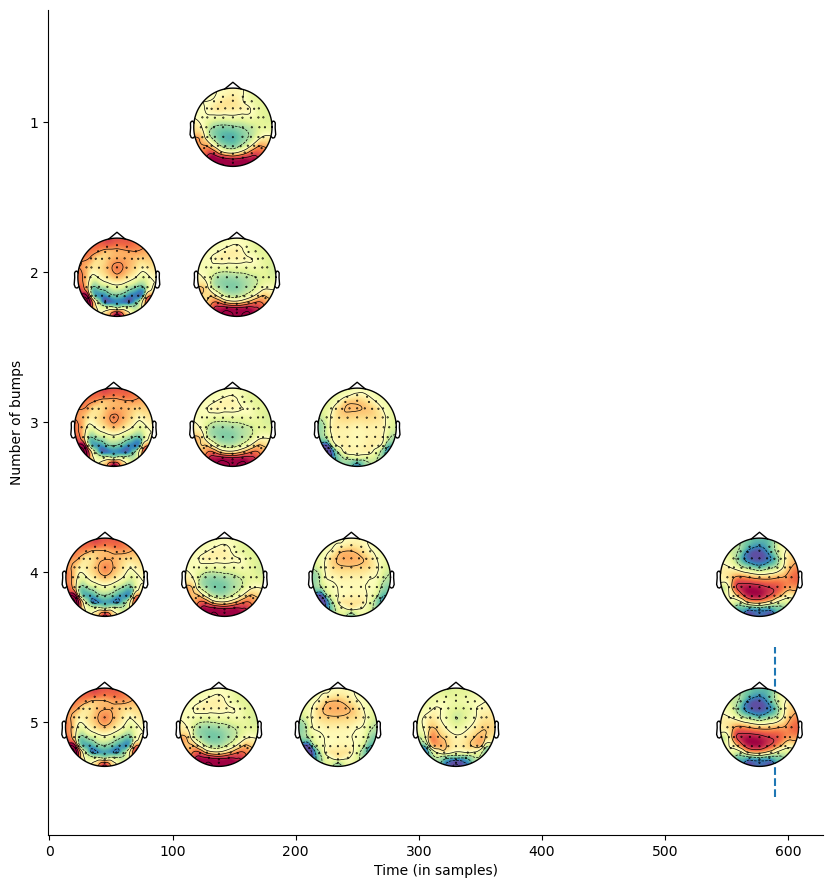

In [18]:
electrodes = xr.DataArray(hsmm.utils.reconstruct(bests.magnitudes, PCs, 
                            explained_var, means.data))

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init.bump_times(x),axis=0) for x in bests.eventprobs],
                          raw.pick_types(eeg=True).info, bump_size=init.bump_width_samples, time_step = 1, magnify=3, 
                          times_to_display = np.mean(hsmm_data.ends.data - hsmm_data.starts.data), 
                          figsize=(10,10), ylabels={'Number of bumps':np.arange(init.max_bumps,0,-1)})

In [10]:
filename = 'SAT_loocv_%s.nc'%version

if filename not in os.listdir(path):
    temp = hsmm_data.unstack().data

    subjects_idx = epoch_data.participant.values
    likelihoods_loo = []

    all_n_bumps = []
    for n_bumps in np.arange(1,init.max_bumps+1):    
        with multiprocessing.Pool(processes=cpus) as pool:
            loo = pool.starmap(hsmm.utils.LOOCV, 
                zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                    itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
        all_n_bumps.append(loo)

    loocv = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                               "participants":np.array(all_n_bumps)[0,:,1]})
    loocv.to_netcdf(path+filename)
else:
    loocv = xr.open_dataset(path+filename)
    loocv = loocv.rename({'__xarray_dataarray_variable__':'data'})#To correct
loocv

<xarray.Dataset>
Dimensions:       (participants: 19, n_bump: 5)
Coordinates:
  * participants  (participants) object 'S8' 'S6' 'S1' 'S18' ... 'S20' 'S2' 'S5'
  * n_bump        (n_bump) int32 1 2 3 4 5
Data variables:
    data          (n_bump, participants) float64 ...

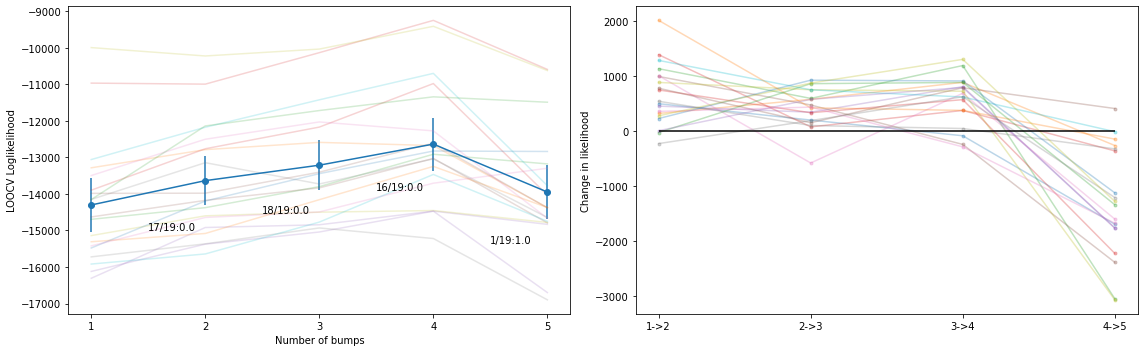

In [11]:
hsmm.visu.plot_LOOCV(loocv.data)

# Estimating separate magnitudes for left and right stimulus (expecting left and right LRPs)

In [12]:
subset = hsmm_dat.where(epoch_data.event.str.contains('left'),drop=True)
hsmm_l_data = hsmm.utils.stack_data(subset,'participant')
init_l = hsmm.models.hsmm(hsmm_l_data.data.T, hsmm_l_data.starts.data, hsmm_l_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_parameters=False)

subset = hsmm_dat.where(epoch_data.event.str.contains('right'),drop=True)
hsmm_r_data = hsmm.utils.stack_data(subset,'participant')
init_r = hsmm.models.hsmm(hsmm_r_data.data.T, hsmm_r_data.starts.data, hsmm_r_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_parameters=False)

In [13]:
left_stim = init_l.fit_single(5, parameters=bests.sel(n_bumps=5).parameters)
right_stim = init_r.fit_single(5, parameters=bests.sel(n_bumps=5).parameters)

Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


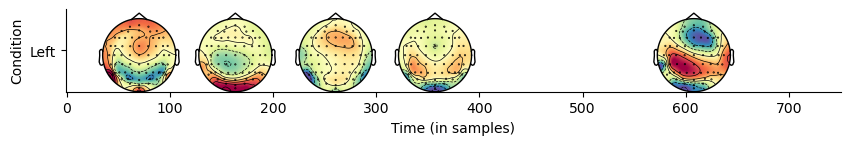

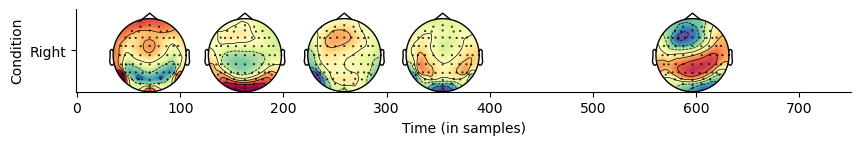

In [16]:
for condition in zip([left_stim, right_stim],
                     [init_l, init_r],
                     [hsmm_l_data, hsmm_r_data],
                    ['Left', 'Right']):
    electrodes = xr.DataArray(hsmm.utils.reconstruct(condition[0].magnitudes, PCs, explained_var, means.data))
    hsmm.visu.plot_topo_timecourse(electrodes, np.mean(condition[1].bump_times(condition[0].eventprobs), axis=0),
                          raw.pick_types(eeg=True).info, bump_size=condition[1].bump_width_samples, time_step = 1,  
                          times_to_display = np.mean(condition[2].ends.data - condition[2].starts.data),max_time=750,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=5)

# Estimating separate stage duration for speed and accuracy

In [19]:
subset = hsmm_dat.where(epoch_data.event.str.contains('speed'),drop=True)
hsmm_speed_data = hsmm.utils.stack_data(subset,'participant')
init_speed = hsmm.models.hsmm(hsmm_speed_data.data.T, hsmm_speed_data.starts.data, hsmm_speed_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_magnitudes=False)

subset = hsmm_dat.where(epoch_data.event.str.contains('accuracy'),drop=True)
hsmm_accuracy_data = hsmm.utils.stack_data(subset,'participant')
init_accuracy = hsmm.models.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus, estimate_magnitudes=False)

In [20]:
speed = init_speed.fit_single(5, magnitudes=bests.sel(n_bumps=5).magnitudes)
accuracy = init_accuracy.fit_single(5, magnitudes=bests.sel(n_bumps=5).magnitudes)

Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


In [21]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [speed, accuracy]):
    condition_times.append(cond[0].bump_times(cond[1].eventprobs.dropna('bump')))
condition_times = np.array(condition_times,dtype=object)


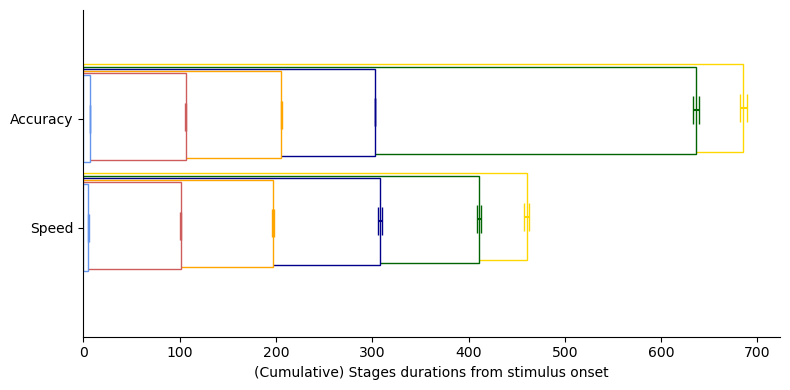

In [22]:
hsmm.visu.plot_latencies_average(condition_times, init.bump_width_samples, 1000/init.sf, 
                labels= ['Speed', 'Accuracy'], errs='ci');

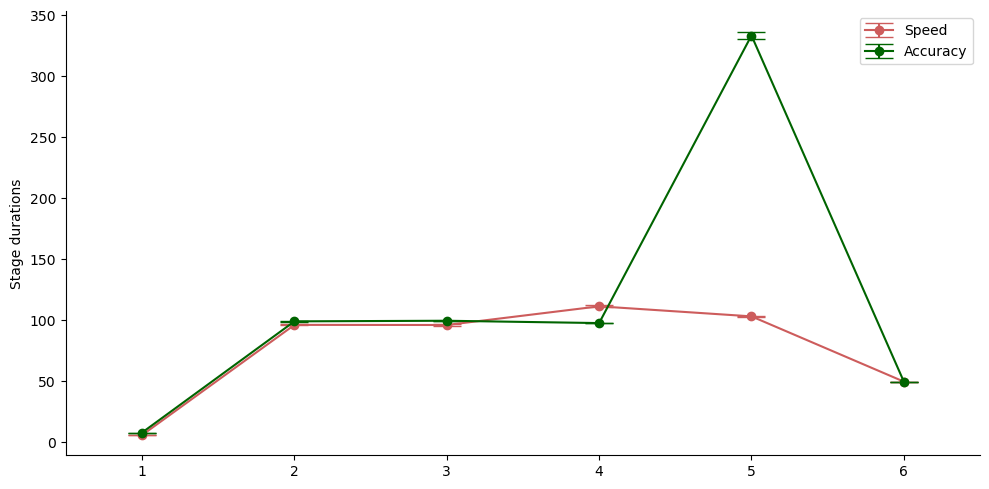

In [23]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels= ['Speed', 'Accuracy'], errs='ci', time_step=1000/init.sf,
    colors=["indianred","darkgreen"], figsize=(10,5));

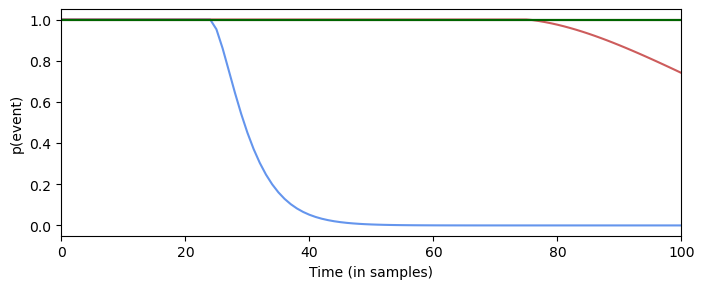

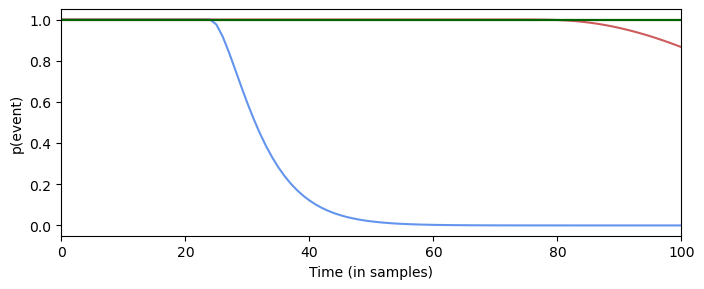

In [24]:
hsmm.visu.plot_distribution(speed.eventprobs.mean(dim=['trial']), xlims=(0,100), survival=True)
hsmm.visu.plot_distribution(accuracy.eventprobs.mean(dim=['trial']), xlims=(0,100), survival=True);

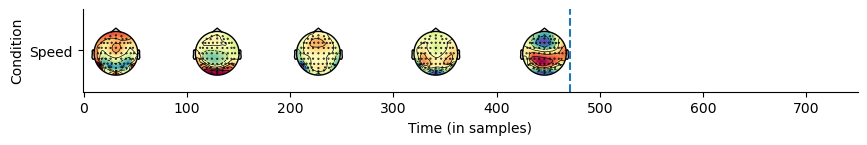

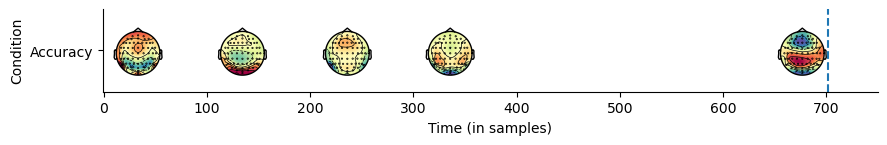

In [25]:
for condition in zip([speed, accuracy],
                     [init_speed, init_accuracy],
                     [hsmm_speed_data, hsmm_accuracy_data],
                    ['Speed', 'Accuracy']):
    electrodes = xr.DataArray(hsmm.utils.reconstruct(condition[0].magnitudes, PCs, explained_var, means.data))
    hsmm.visu.plot_topo_timecourse(electrodes, np.mean(condition[1].bump_times(condition[0].eventprobs), axis=0),
                          raw.pick_types(eeg=True).info, bump_size=condition[1].bump_width_samples, time_step = 1,  
                          times_to_display = np.mean(condition[2].ends.data - condition[2].starts.data),max_time=750,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=2)

# Applying HsMM separately for the speed condition

Initializing data for the speed condition

In [26]:
subset = hsmm_dat.where(epoch_data.event.str.contains('speed'),drop=True)
hsmm_speed_data = hsmm.utils.stack_data(subset,'participant')
init_speed = hsmm.models.hsmm(hsmm_speed_data.data.T, hsmm_speed_data.starts.data, hsmm_speed_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [27]:
filename = 'SAT_bests_speed_%s.nc'%version

if filename not in os.listdir(path):
    bests_speed = init.backward_estimation(max_starting_points=200)
    bests_speed.to_netcdf(path+filename)
else:
    bests_speed = xr.open_dataset(path+filename)
bests_speed

<xarray.Dataset>
Dimensions:      (n_bumps: 5, samples: 1972, trial: 20110, bump: 5, component: 10, stage: 6, params: 2)
Coordinates:
  * n_bumps      (n_bumps) int32 5 4 3 2 1
Dimensions without coordinates: samples, trial, bump, component, stage, params
Data variables:
    eventprobs   (n_bumps, samples, trial, bump) float64 ...
    magnitudes   (n_bumps, component, bump) float64 ...
    parameters   (n_bumps, stage, params) float64 ...
    likelihoods  (n_bumps) float64 ...

## Plotting the bump placement from this method

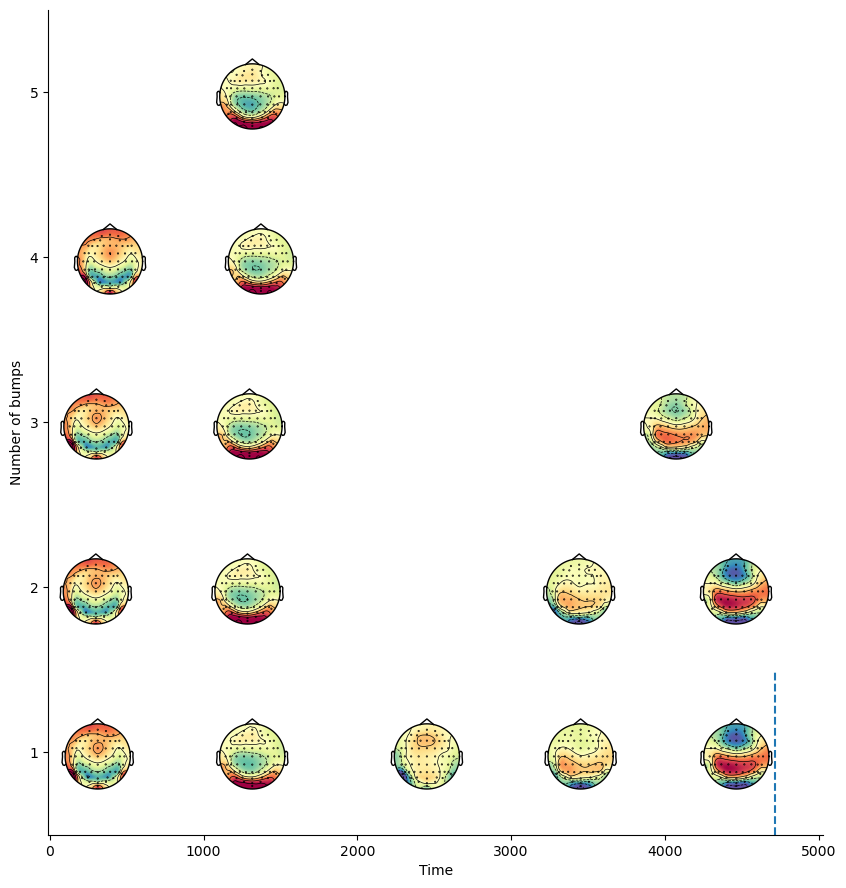

In [28]:
electrodes = xr.DataArray(hsmm.utils.reconstruct(bests_speed.magnitudes, PCs, 
                            explained_var, means.data))

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init_speed.bump_times(x),axis=0) for x in bests_speed.eventprobs],
                          raw.pick_types(eeg=True).info, bump_size=init_speed.bump_width_samples, time_step = 10, magnify=2, 
                          times_to_display = np.mean(hsmm_speed_data.ends.data - hsmm_speed_data.starts.data), 
                          figsize=(10,10), ylabels={'Number of bumps':np.arange(init_speed.max_bumps)+1})

In [29]:
filename = 'SAT_loocv_speed_%s.nc'%version

if filename not in os.listdir(path):
    temp = hsmm_data.unstack().data

    subjects_idx = epoch_data.participant.values
    likelihoods_loo = []

    all_n_bumps = []
    for n_bumps in np.arange(1,init.max_bumps+1):    
        with multiprocessing.Pool(processes=cpus) as pool:
            loo = pool.starmap(hsmm.utils.LOOCV, 
                zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                    itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
        all_n_bumps.append(loo)

    loocv_speed = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                               "participants":np.array(all_n_bumps)[0,:,1]})
    loocv_speed.to_netcdf(path+filename)
else:
    loocv_speed = xr.open_dataset(path+filename)
    loocv_speed = loocv_speed.rename({'__xarray_dataarray_variable__':'data'})#To correct
loocv_speed

<xarray.Dataset>
Dimensions:       (participants: 19, n_bump: 5)
Coordinates:
  * participants  (participants) object 'S8' 'S6' 'S1' 'S18' ... 'S20' 'S2' 'S5'
  * n_bump        (n_bump) int32 1 2 3 4 5
Data variables:
    data          (n_bump, participants) float64 ...

Plotting LOOCV along with pvalues from the sign test

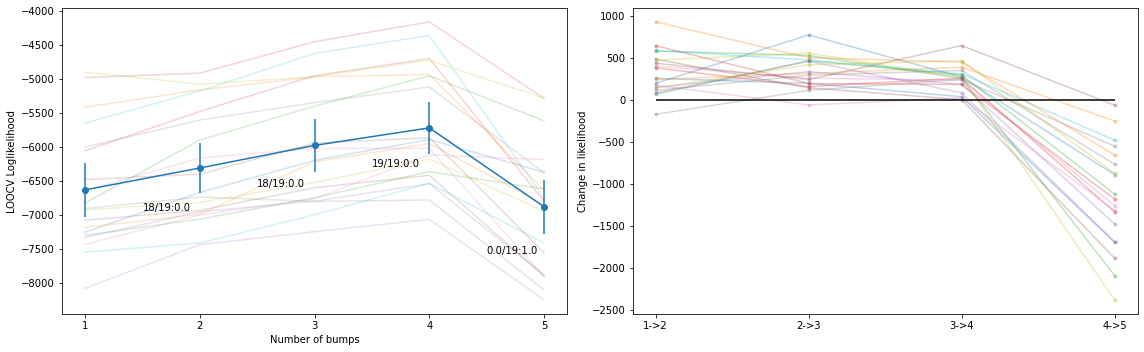

In [30]:
hsmm.visu.plot_LOOCV(loocv_speed.data)

# Applying HsMM separately for the accuracy condition

Initializing data for the accuracy condition

In [43]:
subset = hsmm_dat.where(epoch_data.event.str.contains('accuracy'),drop=True)
hsmm_accuracy_data = hsmm.utils.stack_data(subset,'participant')
init_accuracy = hsmm.models.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [44]:
filename = 'SAT_bests_accuracy_%s.nc'%version

if filename not in os.listdir(path):
    bests_accuracy = init_accuracy.backward_estimation(max_starting_points=1)
    bests_accuracy.to_netcdf(path+filename)
else:
    bests_accuracy = xr.open_dataset(path+filename)
bests_accuracy

Estimating all solutions for maximal number of bumps (5) with 0 random starting points
Estimating parameters for 5 bumps model
Parameters estimated for 5 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 5, stage: 6, params: 2, component: 10, bump: 5, samples: 2046, trial: 20968)
Coordinates:
  * n_bumps      (n_bumps) int64 5 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -1.216e+05 -1.227e+05 ... -1.406e+05
    parameters   (n_bumps, stage, params) float64 2.0 7.634 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.6364 0.5212 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

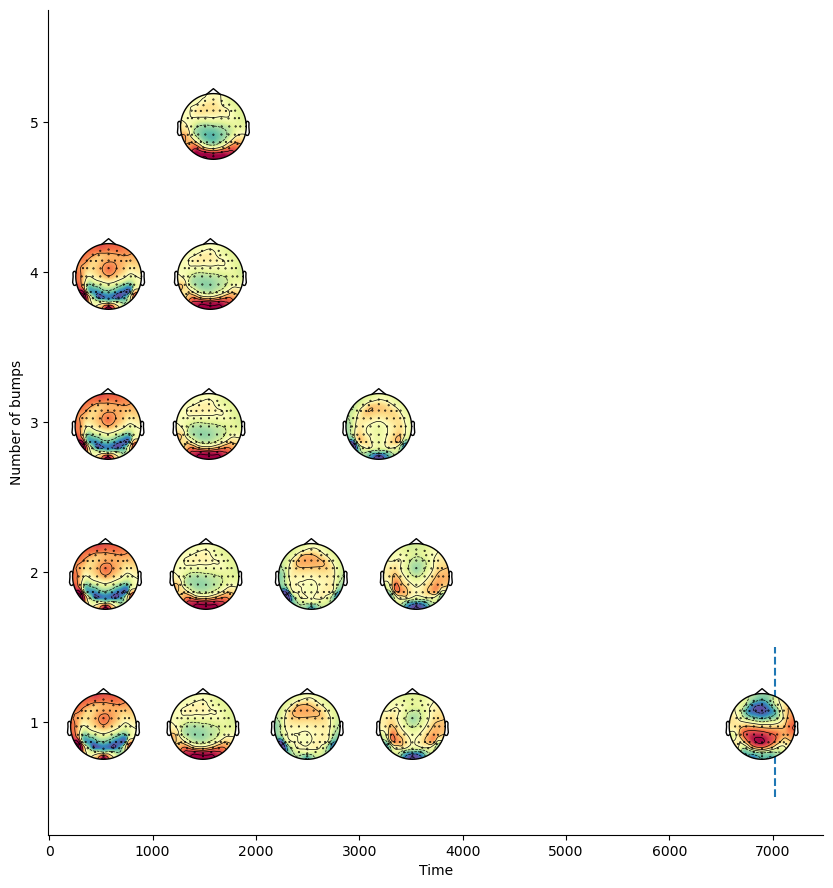

In [45]:
electrodes = xr.DataArray(hsmm.utils.reconstruct(bests_accuracy.magnitudes, PCs, 
                            explained_var, means.data))

hsmm.visu.plot_topo_timecourse(electrodes, [np.mean(init_accuracy.bump_times(x),axis=0) for x in bests_accuracy.eventprobs],
                          raw.pick_types(eeg=True).info, bump_size=init_speed.bump_width_samples, time_step = 10, magnify=3, 
                          times_to_display = np.mean(hsmm_accuracy_data.ends.data - hsmm_accuracy_data.starts.data), 
                          figsize=(10,10), ylabels={'Number of bumps':np.arange(init_speed.max_bumps)+1})

In [ ]:
filename = 'SAT_loocv_accuracy_%s.nc'%version

if filename not in os.listdir(path):
    temp = hsmm_data.unstack().data

    subjects_idx = epoch_data.participant.values
    likelihoods_loo = []

    all_n_bumps = []
    for n_bumps in np.arange(1,init.max_bumps+1):    
        with multiprocessing.Pool(processes=cpus) as pool:
            loo = pool.starmap(hsmm.utils.LOOCV, 
                zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                    itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
        all_n_bumps.append(loo)

    loocv_accuracy = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init.max_bumps+1),
                                                               "participants":np.array(all_n_bumps)[0,:,1]})
    loocv_accuracy.to_netcdf(path+filename)
else:
    loocv_accuracy = xr.open_dataset(path+filename)
    loocv_accuracy = loocv_accuracy.rename({'__xarray_dataarray_variable__':'data'})#To correct
loocv_accuracy

In [ ]:
hsmm.visu.plot_LOOCV(loocv_accuracy.data)

# Inspecting best models

In [47]:
estimates_speed = bests_speed.sel(n_bumps=4).drop_vars('n_bumps')
estimates_accuracy = bests_accuracy.sel(n_bumps=5).drop_vars('n_bumps')

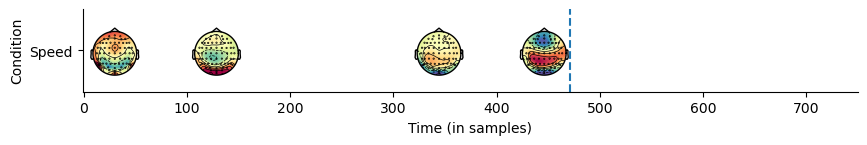

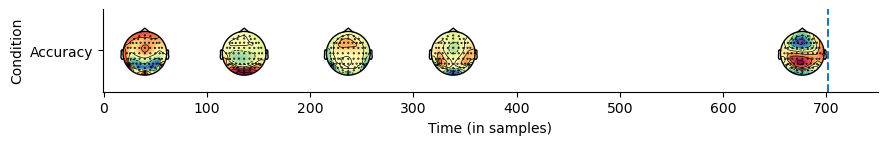

In [49]:
for condition in zip([estimates_speed, estimates_accuracy],
                     [init_speed, init_accuracy],
                     [hsmm_speed_data, hsmm_accuracy_data],
                    ['Speed', 'Accuracy']):
    electrodes = xr.DataArray(hsmm.utils.reconstruct(condition[0].magnitudes, PCs, explained_var, means.data))
    hsmm.visu.plot_topo_timecourse(electrodes, np.mean(condition[1].bump_times(condition[0].eventprobs), axis=0),
                          raw.pick_types(eeg=True).info, bump_size=condition[1].bump_width_samples, time_step = 1,  
                          times_to_display = np.mean(condition[2].ends.data - condition[2].starts.data),max_time=750,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]}, magnify=2)

In [50]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [estimates_speed, estimates_accuracy]):
    condition_times.append(cond[0].bump_times(cond[1].eventprobs.dropna('bump')))
condition_times = np.array(condition_times,dtype=object)

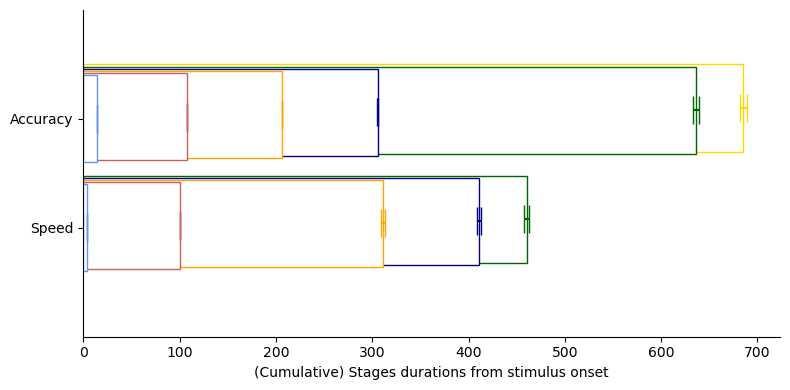

In [51]:
hsmm.visu.plot_latencies_average(condition_times, init.bump_width_samples, 1000/init.sf, 
                labels= ['Speed', 'Accuracy'], errs='ci');

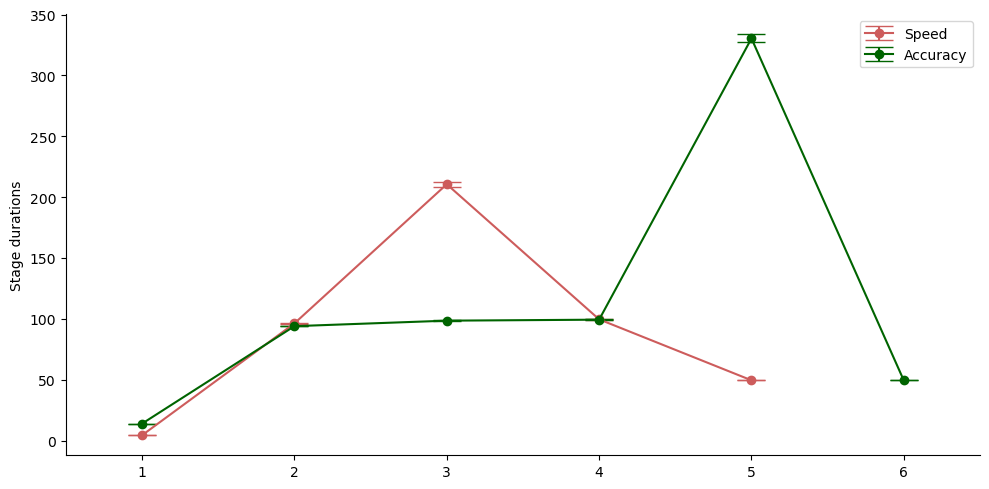

In [52]:
hsmm.visu.plot_latencies(condition_times,
    init.bump_width_samples, kind='point',legend=True,
    labels= ['Speed', 'Accuracy'], errs='ci', time_step=1000/init.sf,
    colors=["indianred","darkgreen"], figsize=(10,5));

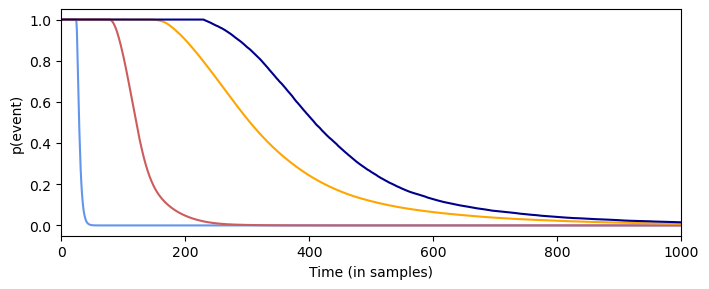

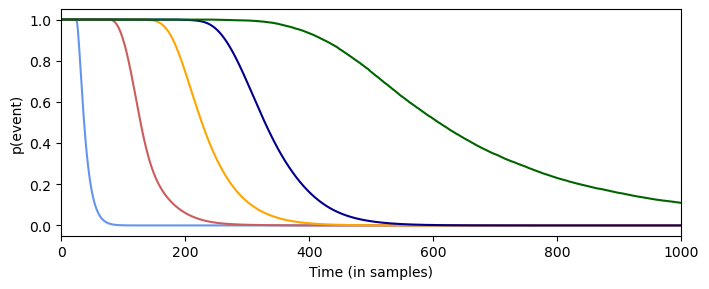

In [54]:
hsmm.visu.plot_distribution(estimates_speed.eventprobs.mean(dim=['trial']), xlims=(0,1000), survival=True)
hsmm.visu.plot_distribution(estimates_accuracy.eventprobs.mean(dim=['trial']), xlims=(0,1000), survival=True);